<iframe width="768" height="480" src="https://www.youtube.com/embed/r6FXMZJGecg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

 Introduction:

Develope model to automatically segment the stomach and intestines on MRI scans. The MRI scans are from actual cancer patients who had 1-5 MRI scans on separate days during their radiation treatment. You'll base your algorithm on a dataset of these scans to come up with creative deep learning solutions that will help cancer patients get better care.



What is MRI Scan





Magnetic resonance imaging (MRI) is a medical imaging technique that uses a magnetic field and computer-generated radio waves to create detailed images of the organs and tissues in your body.

Most MRI machines are large, tube-shaped magnets. When you lie inside an MRI machine, the magnetic field temporarily realigns water molecules in your body. Radio waves cause these aligned atoms to produce faint signals, which are used to create cross-sectional MRI images — like slices in a loaf of bread.

Reference : https://www.mayoclinic.org/tests-procedures/mri/about/pac-20384768

The structure and bed below shows the MRI setup



## The Video talks about how to interpret the CT scan along with organs present in the scan

In [ ]:
from IPython.display import YouTubeVideo
# Full Link: https://www.youtube.com/embed/r6FXMZJGecg

YouTubeVideo('r6FXMZJGecg', width=700, height=400)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Let us understand the training data

In [ ]:
# Reading training meta data
train_df = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")

In [ ]:
train_df.head(5)

In [ ]:
train_df.info()

## Let us write a function to extract case-id,day and slice from the meta data

In [ ]:
import re

In [ ]:
#Extract fields from column and create sepearate columns from it
def extract_caseId(id_col):
    matches = re.findall(r'\d+', id_col)
    return matches[0]

def extract_day(id_col):
    matches = re.findall(r'\d+', id_col)
    return matches[1]

def extract_scan(id_col):
    matches = re.findall(r'\d+', id_col)
    return matches[2]
    
    
    

In [ ]:
#Creating separate columns for meta data
train_df['caseId'] = train_df['id'].apply(extract_caseId)
train_df['day'] = train_df['id'].apply(extract_day)
train_df['scan'] = train_df['id'].apply(extract_scan)

## Visualizing the frequency of class

In [ ]:
train_df['class'].hist()

In [ ]:
from glob import glob
def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")
    # returning the first file, though it will always hold one file.
    return file[0]
train_df["path"] = train_df["id"].apply(lambda x: fetch_file_from_id("../input/uw-madison-gi-tract-image-segmentation/train", x))
train_df.head()

In [ ]:
# We need to generate mask
train_df['Height'] = train_df["path"].apply(lambda x: x.split('_')[3])
train_df['Width'] = train_df["path"].apply(lambda x: x.split('_')[4])

In [ ]:
train_df.head(5)

In [ ]:
train_df["path"][0].split('_')

In [ ]:
#Unique combinations of height and width
crosstab = pd.crosstab(train_df['Height'],train_df['Width'])
crosstab

It seems we only have a squared resolution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import pandas

## Let us check the segmentation of the images

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
# Filter data only with mask segment being not NaN
images_with_segmentation_mask = train_df.dropna(subset=['segmentation'])[
    ['id','class','segmentation','caseId','day','scan','path','Height','Width']]

In [ ]:
images_with_segmentation_mask.shape

Nearly 1/3 of the images have masks

In [ ]:
#Let us take first case for sample
case_123 = images_with_segmentation_mask[images_with_segmentation_mask['id'].str.contains("case123_day")]

In [ ]:
case_123.shape

In [ ]:
case_123.head(10)

Reading case_123 sample images

In [ ]:
import cv2

In [ ]:
def read_image(path):
    '''Reads and converts the image.
    path: the full complete path to the .png file'''

    # Read image in a corresponding manner
    # convert int16 -> float32
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype('float32')
    # Scale to [0, 255]
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.uint8)
    
    return image

In [ ]:
def show_simple_images(sample_paths, image_names="sample_images"):
    '''Displays simple images (without mask).'''

    # Get additional info from the path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]


    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 8))
    axs = axs.flatten()
    wandb_images = []

    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, 
                         color = "#61783F", weight='bold')

        img = read_image(path)
        #wandb_images.append(wandb.Image(img))
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

    

In [ ]:
CASE = "case123"

# Sample a few images from speciffied case
path = train_df[(train_df["segmentation"].isna()==False) & (train_df['id'].str.contains(CASE))]["path"]\
                .reset_index().groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(path, image_names="case123_samples")

## How Segmentation works

Let us consider example of segmentation field

45601 5 45959 10 46319 12 46678 14 47037 16 47396 18 47756 18 48116 19 48477 18 48837 19 \
                49198 19 49558 19 49919 19 50279 20 50639 20 50999 21 51359 21 51719 22 52079 22 52440 22 52800 22 53161 21 \
                53523 20 53884 20 54245 19 54606 19 54967 18 55328 17 55689 16 56050 14 56412 12 56778 4 57855 7 58214 9 58573 12 \
                58932 14 59292 15 59651 16 60011 17 60371 17 60731 17 61091 17 61451 17 61812 15 62172 15 62532 15 62892 14 \
                63253 12 63613 12 63974 10 64335 7

Now let us take first example 45601 and 5 it talks about starting point of the segment which is
45601 and 5 being the length.

Now Let us write function to get the masks given a case id image with its segment details

The following methods were inspired from the notebook below
[https://www.kaggle.com/code/andradaolteanu/aw-madison-eda-in-depth-mask-exploration](http://)

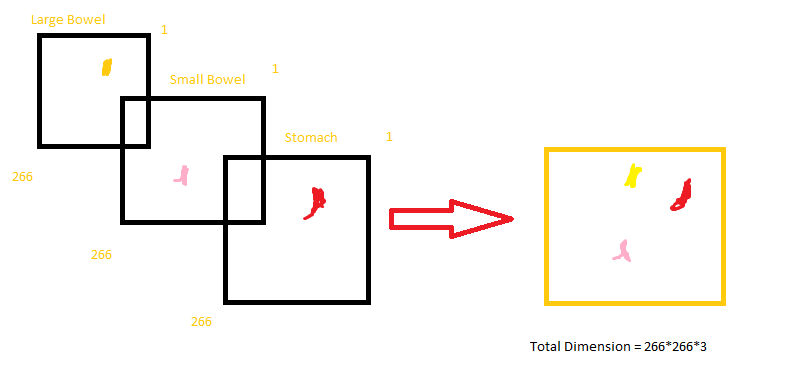

In [ ]:
#read the first segmentation for sample
sample_segmentation = case_123.iloc[3]['segmentation']
sample_shape = (int(case_123.iloc[3]['Height']),int(case_123.iloc[0]['Width']))

def mask_from_segmentation(segmentation, shape):
    '''Returns the mask corresponding to the inputed segmentation.
    segmentation: a list of start points and lengths in this order
    max_shape: the shape to be taken by the mask
    return:: a 2D mask'''

    # Get a list of numbers from the initial segmentation
    segm = np.asarray(segmentation.split(), dtype=int)

    # Get start point and length between points
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    # Compute the location of each endpoint
    end_point = start_point + length_point

    # Create an empty list mask the size of the original image
    # take onl
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Change pixels from 0 to 1 that are within the segmentation
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

In [ ]:
print("Sample Segmentation :",sample_segmentation)
print("\n")
print("Sample Shape :",sample_shape)

In [ ]:
case_mask = mask_from_segmentation(sample_segmentation, sample_shape)

plt.figure(figsize=(5, 5))
plt.title("Mask Example:")
plt.imshow(case_mask)
plt.axis("off")
plt.show();

In [ ]:
ID_data = train_df[train_df["id"]=='case123_day20_slice_0072'].reset_index(drop=True)

We could see the segmentation field helps in the extraction of mask from the image

In [ ]:
def get_id_mask(ID, verbose=False):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask'''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train_df[train_df["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data.loc[k, :] for k in range(3)]


    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = int(max([obs[7]  for obs in observations]))
    max_width = int(max([obs[7] for obs in observations]))

    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = observations[k]
            segmentation = observation.segmentation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

    # If no segmentation was found skip
    elif max_segmentation == 0:
        mask = None
        if verbose:
            print("None of the classes have segmentation.")
            
    return mask

In [ ]:
# Full Example
path = '../input/uw-madison-gi-tract-image-segmentation/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.png'
img = read_image(path)

# Get mask

ID = "case131_day0_slice_0066"
mask = get_id_mask(ID, verbose=True)

In [ ]:
mask.shape

In [ ]:
# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
#This is to provide color for different marker
# --- Custom Color Maps ---
# Yellow Purple Red
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Large Bowel", "Small Bowel", "Stomach"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [ ]:
def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    plt.show()

In [ ]:
plot_original_mask(img, mask, alpha=1)

In [ ]:

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = "#61783F", weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

In [ ]:
train_df.head(5)

In [ ]:
# Filter out all instances with no segmentation
data = train_df[train_df["segmentation"].isna()==False].reset_index(drop=True)

In [ ]:
# Get random case
case = "80"
day="10"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["caseId"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_id_mask(i, verbose=False) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

## Let us look how segmentation appears in training data

In [ ]:
data.head(5)

In [ ]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
data.groupby(['Height','class']).count()['segmentation'].unstack().plot(ax=ax)

We could see from top that the pattern is consistent across classes we have maximum resolution for 266 and 360

In [ ]:
# We are going to count for each label the number of segmentation non null per slide.
COLORS = ["red", "blue", "green"]

plt.figure()

for i, label in enumerate(data["class"].unique()):
    data[data["class"] == label][["scan", "segmentation"]].groupby("scan")["segmentation"].count().plot(color = COLORS[i], label = label)

plt.legend()
plt.show()

We could see from top that for stomach the slices around 72 mostly for bowels around 100 or greater than 100 that has segments

In [ ]:
plt.figure(figsize=(15,8))
data["day"] = pd.to_numeric(data["day"])
data["scan"] = pd.to_numeric(data["scan"])
sns.stripplot(x='day', y='scan', data=data, jitter=True, hue='class', dodge=True, palette='viridis')
plt.title("Distribution of scan with date and its effect on class")

There appears to be a discontinutity in the 17th day where stomach has no slices between 20 to 40. Overall stomach has slightly lower number of scans

In [ ]:
df = data.groupby(['caseId', 'day']).count()     
day_vs_count = df.reset_index()
day_vs_count.plot(x="day", y="id", kind="scatter")

We could see most number of days is between 10 to 30 days.

Number of days near zero has consistent pattern 

## Next we can create masked label and prep the data for training which would also include augumentation 